In [1]:
from datetime import datetime

start_time = datetime.now()

# Libraries to install
# %pip install pandas-profiling

%matplotlib inline
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA

print("LOAD DURATION: ", datetime.now() - start_time)  # load time about 30 seconds

LOAD DURATION:  0:00:02.196233


In [55]:
%%time
mydata = pd.read_csv("NY property data.csv")

CPU times: user 3.84 s, sys: 1 s, total: 4.85 s
Wall time: 4.86 s


### Data Imputation

In [56]:
### Remove Gov. Owners
remove_list = [
    "PARKCHESTER PRESERVAT",
    "PARKS AND RECREATION",
    "DCAS",
    "HOUSING PRESERVATION",
    "CITY OF NEW YORK",
    "DEPT OF ENVIRONMENTAL",
    "BOARD OF EDUCATION",
    "NEW YORK CITY HOUSING",
    "CNY/NYCTA",
    "NYC HOUSING PARTNERSH",
    "DEPARTMENT OF BUSINES",
    "DEPT OF TRANSPORTATIO",
    "MTA/LIRR",
    "PARCKHESTER PRESERVAT",
    "MH RESIDENTIAL 1, LLC",
    "LINCOLN PLAZA ASSOCIA",
    "UNITED STATES OF AMER",
    "U S GOVERNMENT OWNRD",
    "THE CITY OF NEW YORK",
    "NYS URBAN DEVELOPMENT",
    "NYS DEPT OF ENVIRONME",
    "CULTURAL AFFAIRS",
    "DEPT OF GENERAL SERVI",
    "DEPT RE-CITY OF NY",
]

property_data = mydata[~mydata["OWNER"].isin(remove_list)].reset_index(drop=True)
property_data.head(10)
NY_data_orig = property_data.copy()

In [4]:
### Missing Zip
missing_zips = np.where(pd.isnull(property_data["ZIP"]))[0]
len(missing_zips)

21772

In [5]:
for i in range(len(missing_zips)):
    if (
        property_data.loc[missing_zips[i] + 1, "ZIP"]
        == property_data.loc[missing_zips[i] - 1, "ZIP"]
    ):
        property_data.loc[missing_zips[i], "ZIP"] = property_data.loc[
            missing_zips[i] - 1, "ZIP"
        ]

In [6]:
missing_zips = np.where(pd.isnull(property_data["ZIP"]))[0]
len(missing_zips)

10245

In [7]:
for i in range(len(missing_zips)):
    property_data.loc[missing_zips[i], "ZIP"] = property_data.loc[
        missing_zips[i] - 1, "ZIP"
    ]

In [8]:
missing_zips = np.where(pd.isnull(property_data["ZIP"]))[0]
len(missing_zips)

0

In [9]:
### Means for FULLVAL, AVLAND, AVTOT by taxclass

property_data["FULLVAL"].replace("Nan", 0)
temp = property_data[property_data["FULLVAL"] != 0]
mean_fullval = temp.groupby("TAXCLASS")["FULLVAL"].mean()
print(mean_fullval)

TAXCLASS
1     5.700059e+05
1A    3.352942e+05
1B    3.738399e+05
1C    7.615359e+05
1D    2.233614e+07
2     8.005832e+05
2A    8.639066e+05
2B    1.254525e+06
2C    7.723493e+05
3     8.510005e+04
4     2.772747e+06
Name: FULLVAL, dtype: float64


In [10]:
property_data["AVLAND"].replace("Nan", 0)
temp_avland = property_data[property_data["AVLAND"] != 0]
mean_avland = temp_avland.groupby("TAXCLASS")["AVLAND"].mean()

In [11]:
property_data["AVTOT"].replace("Nan", 0)
temp_avtot = property_data[property_data["AVTOT"] != 0]
mean_avtot = temp_avtot.groupby("TAXCLASS")["AVTOT"].mean()

In [12]:
### Substituting Values for FULLVAL, AVLAND, AVTOT by taxclass

for index in mean_fullval.index:
    property_data.loc[
        (property_data["FULLVAL"] == 0) & (property_data["TAXCLASS"] == index),
        "FULLVAL",
    ] = mean_fullval[index]
    property_data.loc[
        (property_data["AVLAND"] == 0) & (property_data["TAXCLASS"] == index), "AVLAND"
    ] = mean_avland[index]
    property_data.loc[
        (property_data["AVTOT"] == 0) & (property_data["TAXCLASS"] == index), "AVTOT"
    ] = mean_avtot[index]

In [13]:
### Missing Stories

temp = property_data[property_data["STORIES"].isnull()]
len(temp)

43968

In [14]:
temp["TAXCLASS"].value_counts()

1B    19055
4     17979
2      3434
3      2416
1       877
2C      138
2B       34
2A       30
1A        5
Name: TAXCLASS, dtype: int64

In [15]:
mean_stories = property_data.groupby("TAXCLASS")["STORIES"].mean()
print(mean_stories)

TAXCLASS
1      2.111633
1A     1.656867
1B     4.000000
1C     3.052748
1D     1.068966
2     16.310549
2A     2.844032
2B     4.001635
2C     4.744977
3      1.000000
4      5.517257
Name: STORIES, dtype: float64


In [16]:
len(property_data[property_data["STORIES"] == 0])

0

In [17]:
property_data["STORIES"] = property_data["STORIES"].fillna(value=0)
for index in mean_stories.index:
    property_data.loc[
        (property_data["STORIES"] == 0) & (property_data["TAXCLASS"] == index),
        "STORIES",
    ] = mean_stories[index]

In [18]:
property_data.head().transpose()

,0,1,2,3,4
RECORD,1,2,9,10,11
BBLE,1000010101,1000010201,1000041001,1000041002,1000041003
B,1,1,1,1,1
BLOCK,1,1,4,4,4
LOT,101,201,1001,1002,1003
EASEMENT,NaN,NaN,NaN,NaN,NaN
OWNER,U S GOVT LAND & BLDGS,U S GOVT LAND & BLDGS,"TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC"
BLDGCL,P7,Z9,R5,R5,R5
TAXCLASS,4,4,4,4,4
LTFRONT,500,27,0,0,0


In [19]:
property_data.loc[property_data["LTFRONT"] == 0, "LTFRONT"] = np.nan
property_data.loc[property_data["LTDEPTH"] == 0, "LTDEPTH"] = np.nan
property_data.loc[property_data["BLDFRONT"] == 0, "BLDFRONT"] = np.nan
property_data.loc[property_data["BLDDEPTH"] == 0, "BLDDEPTH"] = np.nan
property_data.loc[property_data["LTFRONT"] == 1, "LTFRONT"] = np.nan
property_data.loc[property_data["LTDEPTH"] == 1, "LTDEPTH"] = np.nan
property_data.loc[property_data["BLDFRONT"] == 1, "BLDFRONT"] = np.nan
property_data.loc[property_data["BLDDEPTH"] == 1, "BLDDEPTH"] = np.nan

In [20]:
mean_LTFRONT=property_data.groupby(property_data['TAXCLASS'])['LTFRONT'].mean()
mean_LTDEPTH=property_data.groupby(property_data['TAXCLASS'])['LTDEPTH'].mean()
mean_BLDFRONT=property_data.groupby(property_data['TAXCLASS'])['BLDFRONT'].mean()
mean_BLDDEPTH=property_data.groupby(property_data['TAXCLASS'])['BLDDEPTH'].mean()

In [21]:
for index in mean_LTFRONT.index:    
    property_data.loc[(property_data['LTFRONT'].isnull())&(property_data['TAXCLASS']==index),'LTFRONT']=mean_LTFRONT[index]        
    property_data.loc[(property_data['LTDEPTH'].isnull())&(property_data['TAXCLASS']==index),'LTDEPTH']=mean_LTDEPTH[index]    
    property_data.loc[(property_data['BLDFRONT'].isnull())&(property_data['TAXCLASS']==index),'BLDFRONT']=mean_BLDFRONT[index]    
    property_data.loc[(property_data['BLDDEPTH'].isnull())&(property_data['TAXCLASS']==index),'BLDDEPTH']=mean_BLDDEPTH[index]

### Variable Creation

In [23]:
# convert ZIP to an integer rather than a float
property_data['ZIP'] = property_data['ZIP'].astype(str)
property_data['zip3'] = property_data['ZIP'].str[:3]

In [24]:
property_data['ltsize'] = property_data['LTFRONT'] * property_data['LTDEPTH']
property_data['bldsize'] = property_data['BLDFRONT'] * property_data['BLDDEPTH']
property_data['bldvol'] = property_data['bldsize'] * property_data['STORIES']

In [25]:
property_data['r1'] = property_data['FULLVAL']/property_data['ltsize']
property_data['r2'] = property_data['FULLVAL']/property_data['bldsize']
property_data['r3'] = property_data['FULLVAL']/property_data['bldvol']
property_data['r4'] = property_data['AVLAND']/property_data['ltsize']
property_data['r5'] = property_data['AVLAND']/property_data['bldsize']
property_data['r6'] = property_data['AVLAND']/property_data['bldvol']
property_data['r7'] = property_data['AVTOT']/property_data['ltsize']
property_data['r8'] = property_data['AVTOT']/property_data['bldsize']
property_data['r9'] = property_data['AVTOT']/property_data['bldvol']

In [26]:
ninevars = ['r1','r2','r3','r4','r5','r6','r7','r8','r9']
zip5_mean = property_data.groupby('ZIP')[ninevars].mean()
zip3_mean = property_data.groupby('zip3')[ninevars].mean()
taxclass_mean = property_data.groupby('TAXCLASS')[ninevars].mean()
borough_mean = property_data.groupby('B')[ninevars].mean()
property_data = property_data.join(zip5_mean, on='ZIP', rsuffix='_zip5')
property_data = property_data.join(zip3_mean, on='zip3', rsuffix='_zip3')
property_data = property_data.join(taxclass_mean, on='TAXCLASS', rsuffix='_taxclass')
property_data = property_data.join(borough_mean, on='B', rsuffix='_boro')
rsuffix = ['_zip5', '_zip3', '_taxclass', '_boro']
for var in ninevars:
    for r in rsuffix:
        property_data[str(var)+r] = property_data[var]/property_data[str(var)+r]

In [27]:
property_data.head()

,RECORD,BBLE,B,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,r9_taxclass,r1_boro,r2_boro,r3_boro,r4_boro,r5_boro,r6_boro,r7_boro,r8_boro,r9_boro
0,1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500.000000,...,4.715588,0.113902,7.712077,6.469193,0.241395,16.606462,13.685555,0.198288,14.042014,14.957255
1,2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27.000000,...,42.704717,160.560217,69.841147,58.585497,127.249178,56.239136,46.347248,279.513149,127.165526,135.454020
2,9,1000041001,1,4,1001,NaN,"TRZ HOLDINGS, LLC",R5,4,82.296384,...,0.095917,1.072230,1.421603,0.131586,1.855748,2.499883,0.227331,1.866605,2.588430,0.304237
3,10,1000041002,1,4,1002,NaN,"TRZ HOLDINGS, LLC",R5,4,82.296384,...,0.138618,1.549576,2.054487,0.190167,2.681911,3.612808,0.328536,2.697598,3.740773,0.439680
4,11,1000041003,1,4,1003,NaN,"TRZ HOLDINGS, LLC",R5,4,82.296384,...,0.257740,2.881198,3.820001,0.353586,2.822600,3.802332,0.345771,5.015767,6.955390,0.817518


In [29]:
stats = property_data.iloc[:,36:].describe().transpose()

In [30]:
stats.head()

,count,mean,std,min,25%,50%,75%,max
r1,1046826.0,213.569134,532.563887,0.000391,76.262626,152.857143,243.181818,138637.335044
r2,1046826.0,536.415541,1027.442980,0.000747,211.816413,500.000000,683.823529,310551.569383
r3,1046826.0,244.082078,498.823039,0.000090,82.500000,239.062500,336.231400,227500.000000
r4,1046826.0,10.464667,69.975863,0.000008,2.354081,4.596931,7.225445,22249.802454
r5,1046826.0,22.816766,378.506499,0.000210,6.204263,14.980985,20.286458,334636.373365


In [31]:
stats.to_csv('stats_on_vars.csv')

In [41]:
data = property_data
save_record = data['RECORD']
data = property_data.iloc[:,36:]
#data_orig = property_data.copy()
data.head()

,r1,r2,r3,r4,r5,r6,r7,r8,r9,r1_zip5,...,r9_taxclass,r1_boro,r2_boro,r3_boro,r4_boro,r5_boro,r6_boro,r7_boro,r8_boro,r9_boro
0,40.917782,3994.412456,723.985188,8.079350,788.709805,142.953243,18.413002,1797.485605,325.793334,0.096029,...,4.715588,0.113902,7.712077,6.469193,0.241395,16.606462,13.685555,0.198288,14.042014,14.957255
1,57678.882190,36173.697854,6556.463990,4258.951518,2671.030012,484.122805,25955.496986,16278.164034,2950.408795,135.364878,...,42.704717,160.560217,69.841147,58.585497,127.249178,56.239136,46.347248,279.513149,127.165526,135.454020
2,385.182796,736.308714,14.726174,62.110738,118.729804,2.374596,173.332268,331.338940,6.626779,0.903974,...,0.095917,1.072230,1.421603,0.131586,1.855748,2.499883,0.227331,1.866605,2.588430,0.304237
3,556.662267,1064.105879,21.282118,89.761892,171.587267,3.431745,250.498069,478.847739,9.576955,1.306414,...,0.138618,1.549576,2.054487,0.190167,2.681911,3.612808,0.328536,2.697598,3.740773,0.439680
4,1035.027624,1978.540749,39.570815,94.470682,180.588507,3.611770,465.762431,890.343337,17.806867,2.429076,...,0.257740,2.881198,3.820001,0.353586,2.822600,3.802332,0.345771,5.015767,6.955390,0.817518


In [43]:
#data.drop(columns='RECORD', inplace=True)
data = (data - data.mean())/data.std()
data.head()

,r1,r2,r3,r4,r5,r6,r7,r8,r9,r1_zip5,...,r9_taxclass,r1_boro,r2_boro,r3_boro,r4_boro,r5_boro,r6_boro,r7_boro,r8_boro,r9_boro
0,-0.324189,3.365634,0.962071,-0.034088,2.023461,0.745320,-0.041301,1.874086,0.937911,-0.417857,...,0.660210,-0.374523,3.352458,2.151291,-0.120245,0.910164,0.790755,-0.110174,0.594662,0.887478
1,107.903135,34.685411,12.654552,60.713604,6.996480,2.658471,127.179921,17.407961,8.963675,62.109671,...,7.410371,67.440601,34.383853,22.651090,20.011593,3.221530,2.826725,38.274168,5.752631,8.549314
2,0.322241,0.194554,-0.459794,0.738056,0.253399,-0.042992,0.718576,0.301305,-0.038062,-0.044388,...,-0.160643,0.030529,0.210577,-0.341588,0.135643,0.087473,-0.048164,0.119092,0.072426,-0.044240
3,0.644229,0.513596,-0.446651,1.133208,0.393046,-0.037064,1.097074,0.459542,-0.029041,0.141639,...,-0.153056,0.232287,0.526681,-0.318545,0.266597,0.152378,-0.041856,0.233289,0.124968,-0.035628
4,1.542460,1.403606,-0.409988,1.200500,0.416827,-0.036055,2.152944,0.900967,-0.003875,0.660585,...,-0.131890,0.795117,1.408496,-0.254265,0.288898,0.163431,-0.040781,0.551860,0.271541,-0.011603


(0.0, 1.0)

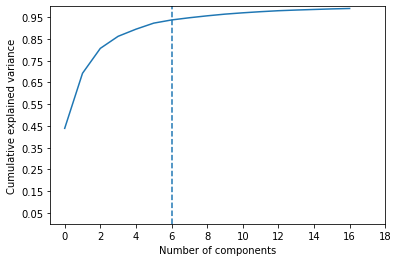

In [44]:
pca = PCA(n_components = .99, svd_solver = 'full')
pca.fit(data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.yticks(np.arange(0.05, 1.1, step=.1))
plt.xticks(np.arange(0, 20, step=2))
plt.axvline(x=6, linestyle='--')
plt.ylim(0,1)

In [45]:
pca = PCA(n_components = 6)
princ_comps = pca.fit_transform(data)
data_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)])
data_pca.shape

(1046826, 6)

In [46]:
pca_mean = data_pca.mean()
pca_sd = data_pca.std()
data_pca = (data_pca - pca_mean) / pca_sd
data_pca.describe()

,PC1,PC2,PC3,PC4,PC5,PC6
count,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06
mean,1.571192e-16,-1.248971e-15,-1.435576e-16,1.608347e-15,-3.197336e-15,-4.552030e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.585169e-01,-2.280285e+02,-1.990058e+02,-2.023902e+02,-2.438864e+02,-2.002481e+02
25%,-1.088008e-01,-1.544611e-01,-1.356178e-01,-3.269413e-02,-1.159060e-01,-1.101851e-01
50%,-2.375699e-02,-5.919442e-02,6.964986e-04,1.366906e-02,-1.313796e-02,-2.535295e-02
75%,3.290240e-02,3.225958e-02,3.206016e-01,7.018407e-02,4.879449e-02,1.382269e-01
max,6.907817e+02,3.239819e+02,5.967327e+02,2.507935e+02,4.068851e+02,4.017196e+02


In [47]:
### Model 1: Z-Score Outliers
p=2
one_over_p = 1/p
score1 = (((data_pca).abs()**p).sum(axis=1))**one_over_p

In [48]:
### Model 2: autoencoder error
from keras.models import Model
from keras.layers import Input, Dense

In [49]:
# placeholder for input
data_in = Input(shape=(6,))
# dimension of the encoded data. Choose 3
encoded_dim = 3
# encoded representation of the data
encoded = Dense(encoded_dim, activation='tanh')(data_in)
# reconstruction of the input
decoded = Dense(6,activation='tanh')(encoded)
# this model maps the input data to the reconstructed data
autoencoder = Model(data_in, decoded)

In [50]:
autoencoder.compile(optimizer='adam', loss="mean_squared_error")

In [51]:
autoencoder.fit(data_pca,data_pca, epochs=3, shuffle=True, validation_data=(data_pca,data_pca))

Epoch 1/3
32714/32714 [==============================] - 66s 2ms/step - loss: 0.7969 - val_loss: 0.8946
Epoch 2/3
32714/32714 [==============================] - 60s 2ms/step - loss: 0.8555 - val_loss: 0.8938
Epoch 3/3
32714/32714 [==============================] - 62s 2ms/step - loss: 0.9740 - val_loss: 0.8924


In [52]:
pca_out = autoencoder.predict(data_pca)
error = pca_out - data_pca
p=2
oop=1/p
score2 = ((error.abs()**p).sum(axis=1))**oop

In [69]:
scores = pd.DataFrame(score1)
scores.columns=['score1']
scores['score2'] = score2
scores['score1 rank'] = scores['score1'].rank()
scores['score2 rank'] = scores['score2'].rank()
scores['final'] = (scores['score1 rank'] + scores['score2 rank'])/2

In [70]:
scores['RECORD'] = save_record
scores.set_index('RECORD', drop=True, inplace=True)

,score1,score2,score1 rank,score2 rank,final
RECORD,,,,,
1,3.811836,2.421600,1032993.0,1033806.0,1033399.5
2,88.407792,86.842493,1046749.0,1046748.0,1046748.5
9,0.590118,0.530112,894887.0,995298.0,945092.5
10,0.941791,0.752573,978678.0,1009927.0,994302.5
11,2.002905,1.226840,1019632.0,1023279.0,1021455.5


In [71]:
NY_data_with_scores = NY_data_orig.join(scores, on='RECORD')
NY_data_with_scores.set_index('RECORD',inplace=True)

In [72]:
NY_data_with_scores.head(20)

,BBLE,B,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,LTDEPTH,...,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE,score1,score2,score1 rank,score2 rank,final
RECORD,,,,,,,,,,,,,,,,,,,,,
1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500,1046,...,8613000.0,NaN,FINAL,2010/11,AC-TR,3.811836,2.421600,1032993.0,1033806.0,1033399.50
2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27,0,...,80690400.0,NaN,FINAL,2010/11,AC-TR,88.407792,86.842493,1046749.0,1046748.0,1046748.50
9,1000041001,1,4,1001,NaN,"TRZ HOLDINGS, LLC",R5,4,0,0,...,NaN,NaN,FINAL,2010/11,AC-TR,0.590118,0.530112,894887.0,995298.0,945092.50
10,1000041002,1,4,1002,NaN,"TRZ HOLDINGS, LLC",R5,4,0,0,...,NaN,NaN,FINAL,2010/11,AC-TR,0.941791,0.752573,978678.0,1009927.0,994302.50
11,1000041003,1,4,1003,NaN,"TRZ HOLDINGS, LLC",R5,4,0,0,...,NaN,NaN,FINAL,2010/11,AC-TR,2.002905,1.226840,1019632.0,1023279.0,1021455.50
12,1000041004,1,4,1004,NaN,"TRZ HOLDINGS, LLC",R5,4,0,0,...,NaN,NaN,FINAL,2010/11,AC-TR,0.430968,0.164966,624466.0,754586.0,689526.00
13,1000041005,1,4,1005,NaN,"TRZ HOLDINGS, LLC",R5,4,0,0,...,NaN,NaN,FINAL,2010/11,AC-TR,0.379748,0.320736,580664.0,938029.0,759346.50
14,1000041006,1,4,1006,NaN,"TRZ HOLDINGS, LLC",R5,4,0,0,...,NaN,NaN,FINAL,2010/11,AC-TR,0.374475,0.304971,575256.0,928334.0,751795.00
15,1000041007,1,4,1007,NaN,"TRZ HOLDINGS, LLC",R5,4,0,0,...,NaN,NaN,FINAL,2010/11,AC-TR,1.386201,0.975983,1006198.0,1017393.0,1011795.50


In [74]:
top_records = NY_data_with_scores.sort_values(['final'], ascending = False).head(100)

,BBLE,B,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,LTDEPTH,...,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE,score1,score2,score1 rank,score2 rank,final
RECORD,,,,,,,,,,,,,,,,,,,,,
917942,4142600001,4,14260,1,NaN,"LOGAN PROPERTY, INC.",T1,4,4910,0,...,4.501180e+09,NaN,FINAL,2010/11,AC-TR,981.327261,981.737626,1046826.0,1046826.0,1046826.0
684704,4036590105,4,3659,105,NaN,W RUFERT,V0,1B,2,2,...,NaN,NaN,FINAL,2010/11,AC-TR,457.056930,455.355849,1046825.0,1046825.0,1046825.0
1065870,5076440001,5,7644,1,NaN,PEOPLE OF THE ST OF N,V0,1B,2891,1488,...,NaN,NaN,FINAL,2010/11,AC-TR,448.086772,446.622718,1046824.0,1046824.0,1046824.0
1059883,5069770012E,5,6977,12,E,NaN,Z7,4,5,5,...,NaN,NaN,FINAL,2010/11,AC-TR,407.134449,405.101234,1046823.0,1046823.0,1046823.0
151044,2024930001,2,2493,1,NaN,NaN,Q6,4,798,611,...,NaN,NaN,FINAL,2010/11,AC-TR,396.024954,394.007122,1046822.0,1046822.0,1046822.0


In [78]:
top_records = top_records.drop(columns = {'score1', 'score2'})

In [79]:
top_records.to_csv('top_records.csv')

In [80]:
top_records.count()

BBLE           100
B              100
BLOCK          100
LOT            100
EASEMENT        16
OWNER           80
BLDGCL         100
TAXCLASS       100
LTFRONT        100
LTDEPTH        100
EXT              4
STORIES         66
FULLVAL        100
AVLAND         100
AVTOT          100
EXLAND         100
EXTOT          100
EXCD1           43
STADDR          93
ZIP             74
EXMPTCL         23
BLDFRONT       100
BLDDEPTH       100
AVLAND2         65
AVTOT2          65
EXLAND2         31
EXTOT2          33
EXCD2            5
PERIOD         100
YEAR           100
VALTYPE        100
score1 rank    100
score2 rank    100
final          100
dtype: int64

(0.1, 2088582.7348885664)

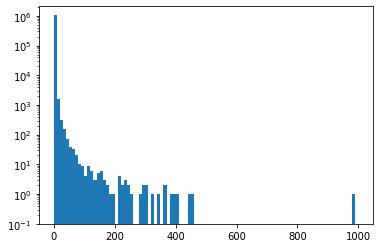

In [61]:
plt.hist(score1, bins = 100, range = (0,1000))
plt.yscale('log')
plt.ylim(ymin=.1)

(0.1, 2090071.3698719037)

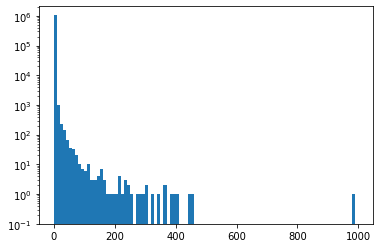

In [62]:
plt.hist(score2, bins =100, range=(0,1000))
plt.yscale('log')
plt.ylim(ymin=.1)

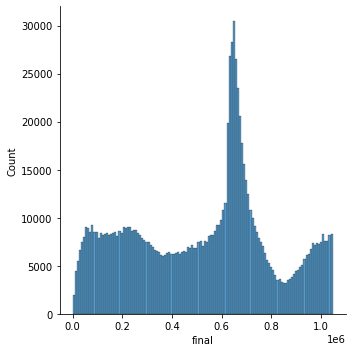

In [64]:
sns.displot(scores['final'])